#                                 Project for neuro-fuzzy computing


##                         Konstantinos Konstntinidis 2546 Stavrinos Nikolaos 2631

Για τη παρουσίαση του project μας επιλέξαμε να τρέξουμε τον κώδικα τοπικά στο jupiter notebook σε environment του tensorflow για cpu έτσι ώστε να μπορέσουμε να περιγράψουμε κάθε κομμάτι του κώδικα ξεχωριστά.



## Επιλέγουμε να κάνουμε train το μοντέλο μας με χρηση της τιμής open από τη κατανομή

In [19]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


# Importing the training set
dataset_train = pd.read_excel('Stock_Price_Training_Data.xlsx')
training_set = dataset_train.iloc[:,1:2].values
print(training_set)

train_data = training_set[0:(len(training_set)-30), :]
valid_data = training_set[(len(training_set)-30):, :]

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]


## Χρησιμοποιυμε scaling των τιμων απο -1 εως 1 
καθως με μεγαλες τιμες το training γινεται ασταθες που σημαίνει ότι μπορεί να υποφέρει από κακή απόδοση κατά τη διάρκεια της μάθησης, με αποτέλεσμα υψηλότερο generalization error.

In [20]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (-1, 1))
training_set_scaled = sc.fit_transform(training_set)

 ## Για το project χωριζουμε το dataset σε training και testing
 Το testing αποτελειται απο τις τελευταιες 30 τιμες του dataset.
 
# Τα δεδομενα μας θα βασιζονται σε προβλεψη 60 timesteps και 1 output
 βάση των προηγούμενων 60 ημερών πρόκειται να προβλέψουμε την τιμή της μετοχής στην 61η μέρα και θα γίνει για όλες τις τιμές του training set -60 μέρες


In [21]:
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

## Τα δεδομενα που θα χρησιμοποιηθουν για το validation των 30 τελευταιων τιμων

In [22]:
model_set = dataset_train.iloc[:, 1:2].values
model_data = model_set[(len(model_set)-len(valid_data)-60):, :]
model_data = model_data.reshape(-1, 1)
model_data_scaled = sc.transform(model_data)

X_test = []
y_test = []
for i in range(60, model_data_scaled.shape[0]):
    X_test.append(model_data_scaled[i-60:i, 0])
    y_test.append(model_data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)


## Reshaping
τα Frameworks όπως Keras / TensorFlow / PyTorch απαιτούν το σύνολο δεδομένων να γίνει reshaped σε άλλη διάσταση που την καθορίζει η δεύτερη του παράμετρος https://www.tensorflow.org/api_docs/python/tf/reshape

In [23]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building the reccurent neural network for our prediction

## Initialising the RNN

Επιλεξαμε την LSTM καθως μπορει να απομνημονεύσει πληροφορίες για μεγάλα χρονικά διαστήματα, και ειναι χρησιμη για μεγαλα input 
files με training data,οπως στη δικια μας περιπτωση.

## Χρησιμοποιόυμε 4 layers της LSTM
Το 1ο και 4ο layer εχουν απο 50 νευρωνες,ενω 2ο και 3ο απο 100 με 1 τελικη εξοδο.Επιση το 1ο layer χρησιμοποιει ως συναρτηση ενεργοποιησης την sigmoid.
Δεν χρησιμοποιησαμε dropout επειδη το LSTM ειναι καλο για long-term υπολογισμους και δεν θελαμε να υπαρχει περιπτωση να χασουμε σημαντικα δεδομενα λογω του dropout.

In [24]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(
    X_train.shape[1], 1), activation='sigmoid', bias_initializer='glorot_uniform'))

regressor.add(LSTM(units=100,  return_sequences=True,
                   bias_initializer='glorot_uniform'))

regressor.add(LSTM(units=100,  return_sequences=True,
                   bias_initializer='glorot_uniform'))

regressor.add(LSTM(units=50, bias_initializer='glorot_uniform'))

regressor.add(Dense(units=1))

## Weight and bias values before training

In [25]:
for layer in regressor.layers:
  print(layer)
  print("Weights :")
  print(layer.get_weights()[0])
  print("Biases:")
  print(layer.get_weights()[1])

Weights :
[[ 0.06978427  0.03428955  0.00471006  0.11903095  0.02977543  0.08985588
  -0.02986185  0.05695322  0.15395784 -0.01070926  0.1692639  -0.07895675
  -0.04708503 -0.04233712 -0.08855015  0.15134168 -0.03678329  0.08434665
   0.067379    0.11493784 -0.05129507  0.12384269 -0.14606981  0.15599188
   0.02270545  0.01419002 -0.11207417 -0.11482954 -0.09461599 -0.08443848
  -0.07844506 -0.12697229 -0.12298742  0.09778669  0.0684236   0.15711406
  -0.10176861 -0.0623043   0.15504923 -0.17107718 -0.06869946  0.01505868
  -0.0470064   0.0284719  -0.00973184  0.08240101  0.12346897 -0.02108008
  -0.12856561 -0.05978262  0.10687181  0.15258709  0.04112519 -0.10605752
   0.03634617  0.12887016 -0.05995047  0.13892734  0.16438788  0.09916201
  -0.02132055 -0.10389854 -0.12308055 -0.13028313 -0.03829618  0.1084547
   0.04807563  0.12905782 -0.01879904 -0.11731781 -0.02056006  0.02269462
  -0.10870298  0.12661976 -0.13816437  0.05203971  0.03925736 -0.0292176
  -0.08018264 -0.15275577 -0.0

In [26]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 100)           60400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 181,451
Trainable params: 181,451
Non-trainable params: 0
_________________________________________________________________


## Setting the optimizer
## Χρησιμοποιούμε τον [adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) με τις βασικές παραμέτρους του όπως χρησιμοποιόυνται και στο site του tensorflow
Ο Adam είναι ένας αλγόριθμος βελτιστοποίησης που μπορεί να χρησιμοποιηθεί αντί της διαδικασίας της κλασικής stochastic gradient descent για την ενημέρωση επαναληπτικών βαρών δικτύου με βάση τα δεδομένα εκπαίδευσης.

In [27]:
optimizer = optimizers.Adam(lr=0.001 , beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


## Loss function
Ορίζουμε ως loss function μας την [mean_squared_error](https://keras.io/api/losses/regression_losses/#mean_squared_error-function)


In [28]:
regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')


## Start the training
Επιλεγουμε batch size=32 και epochs=100 μετα απο αρκετες δοκιμες 

In [29]:
start=time.time()
# Fitting the RNN to the Training set
history = regressor.fit(X_train, y_train, epochs=100,
                        batch_size=32, validation_data=(X_test, y_test))
end=time.time()

Epoch 1/100
37/37 [==============================] - 5s 145ms/step - loss: 0.2895 - val_loss: 0.3847
Epoch 2/100
37/37 [==============================] - 4s 110ms/step - loss: 0.1100 - val_loss: 0.0643
Epoch 3/100
37/37 [==============================] - 4s 108ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 4/100
37/37 [==============================] - 4s 108ms/step - loss: 0.0105 - val_loss: 0.0039
Epoch 5/100
37/37 [==============================] - 4s 102ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 6/100
37/37 [==============================] - 4s 102ms/step - loss: 0.0096 - val_loss: 0.0047
Epoch 7/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0085 - val_loss: 0.0046
Epoch 8/100
37/37 [==============================] - 4s 103ms/step - loss: 0.0068 - val_loss: 0.0131
Epoch 9/100
37/37 [==============================] - 4s 102ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 10/100
37/37 [==============================] - 4s 103ms/step - loss: 0.0071 - val_lo

37/37 [==============================] - 4s 100ms/step - loss: 0.0013 - val_loss: 8.5930e-04
Epoch 82/100
37/37 [==============================] - 4s 104ms/step - loss: 0.0011 - val_loss: 7.4507e-04
Epoch 83/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0015 - val_loss: 9.4089e-04
Epoch 84/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0015 - val_loss: 7.3471e-04
Epoch 85/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 86/100
37/37 [==============================] - 4s 101ms/step - loss: 0.0013 - val_loss: 7.2758e-04
Epoch 87/100
37/37 [==============================] - 4s 102ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 88/100
37/37 [==============================] - 4s 103ms/step - loss: 0.0014 - val_loss: 9.5700e-04
Epoch 89/100
37/37 [==============================] - 4s 110ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 90/100
37/37 [==============================] - 4s 102ms/step - l

In [30]:
print("It took '{}' seconds to to train the model".format(np.round(end-start,4)))

It took '401.2041' seconds to to train the model


## Weight and bias values after training

In [31]:
for layer in regressor.layers:
  print(layer)
  print("Weights :")
  print(layer.get_weights()[0])
  print("Biases:")
  print(layer.get_weights()[1])

Weights :
[[ 0.1735279   0.22014245  0.19403203  0.137317   -0.10809278  0.24910894
  -0.16445641 -0.10955498 -0.02263433 -0.15212595  0.33805805 -0.11422723
   0.15010628 -0.21650754 -0.07263138  0.30811572  0.11241879 -0.07047293
  -0.07289454 -0.07417507 -0.23397282  0.24465008 -0.29328886 -0.03618757
  -0.1375466   0.23052251 -0.2905149  -0.22032166 -0.26831532 -0.2391627
  -0.23253715  0.0271216   0.07809652  0.2549388  -0.11396937  0.30564672
  -0.26610938 -0.2055604  -0.01871049 -0.34394658  0.14445727  0.15721604
  -0.11499289  0.23743393 -0.1844995   0.2451539   0.22922193  0.13953994
   0.01779222  0.09908924  0.20720993  0.34017032  0.2312089  -0.08897481
  -0.10164754  0.29165715 -0.18625505 -0.02945955 -0.01713578 -0.04038443
   0.15320157 -0.12744434  0.07405537 -0.30516702 -0.0329424   0.26739565
   0.1899806  -0.022555   -0.15754476 -0.31083688 -0.20403816  0.13243696
  -0.25263602 -0.05729295 -0.2999927   0.26654547 -0.14250039 -0.13368425
  -0.25665474 -0.30823362 -0.

## Εκτύπωση του loss του μοντελου μας

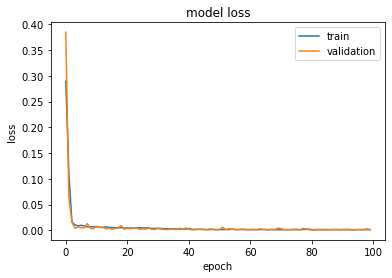

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Αποτιμηση της επιδοση πανω στα δεδομενα 

In [33]:
print("\n\n EVALUATION")
start = time.time()
score = regressor.evaluate(X_test, y_test, batch_size=1)
end = time.time()
print("This test uses the validation set and Testing time took '{}' seconds".format(
    np.round(end - start, 4)))

print("\n", regressor.metrics_names,
      "on the validation dataset is " + str(score))



 EVALUATION
30/30 [==============================] - 0s 10ms/step - loss: 7.4577e-04
This test uses the validation set and Testing time took '2.6605' seconds

 ['loss'] on the validation dataset is 0.0007457686006091535


## Χρονος αποκρισης υπολογισμου prediction

In [34]:
print("\n\n Network response time")
start = time.time()
predicted_stock_price = regressor.predict(X_test)
end = time.time()

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print("This test took '{}' seconds".format(np.round(end - start, 4)))




 Network response time
This test took '1.5476' seconds


## Ο πραγματικος ελεγχος θα γινει απο τον εξεταστη, για τη παρουσιαση ωστοσο κανουμε validation με τα 30 τελευταια στοιχεια του training set

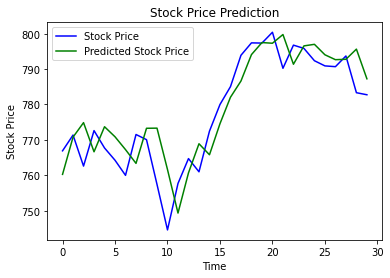

In [35]:
plt.plot(valid_data, color='blue', label='Stock Price')
plt.plot(predicted_stock_price, color='green', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Printing the absolute error

In [36]:
print("\n The mean absolute error is  ", mean_absolute_error(
    valid_data, predicted_stock_price))


 The mean absolute error is   6.066462809244782
